# Simple Metrics
This notebook covers a basic exploration of metrics: which cities have the highest average speed, etc.

# Imports, Methods & Data
These are automatically executed using the initialisation-cells plugin.

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from math import ceil
from pyproj import CRS

import seaborn as sns
sns.set()

from tqdm.notebook import tqdm
tqdm.pandas()

%matplotlib inline

DROOT = './data/'

/Users/ivo/opt/anaconda3/envs/thesis-env/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
def weighted_mean(df, weight='cell_pop'):
    """Returns the weighted mean of a dataframe."""
    return df.apply(lambda x: (x * df[weight]).sum() / df[weight].sum())
    
df = pd.DataFrame({
    "A": [10, 20, 30], 
    "B": [20, 30, 40], 
    "C": [ 1,  2,  3],  })

assert weighted_mean(df, weight='C').B    == (100 / 3)   # 33.333..
assert weighted_mean(df, weight='C').A == (10 / 3 + 20)  # 23.333..

In [6]:
# Load Cities transport times.
gdf_original = gpd.read_file(
    os.path.join(DROOT, '4-processed', 'complete-dataset.gpkg'))
gdf_original = gdf_original.to_crs(epsg=3857)
gdf_total = gdf_original.copy()
gdf_total.head(2)

,city,cell_id,cell_pop,sky_d,walk_d,walk_t,pt_r_d,pt_r_t,pt_r_it,pt_m_d,pt_m_t,pt_m_it,bike_d,bike_t,car_r_d,car_r_t,car_m_d,car_m_t,sky_d_bin,geometry
0,Vienna,0,161.543976,9.995682,11.394,8204.0,11.800,2252.0,NaN,11.800,2192.0,NaN,11.9064,2418.8,12.005,1629.0,12.005,1334.0,9.5,"POLYGON ((1818198.791 6157223.246, 1818145.897..."
1,Vienna,1,55.208580,9.959567,11.228,8085.0,12.074,2384.0,NaN,17.262,3286.0,NaN,11.6706,2371.6,12.577,1800.0,12.577,1505.0,9.5,"POLYGON ((1818556.845 6157223.246, 1818503.941..."


# Procedures

## Mean population weighted route speeds

In [19]:
gdf_total = gdf_original.copy()
gdf_total['car_r_s'] = gdf_total.car_r_d / (gdf_total.car_r_t / 3600)
gdf_total['car_m_s'] = gdf_total.car_m_d / (gdf_total.car_m_t / 3600)
gdf_total['bike_s'] =  gdf_total.bike_d  / (gdf_total.bike_t  / 3600)
gdf_total['walk_s'] =  gdf_total.walk_d  / (gdf_total.walk_t  / 3600)
gdf_total = gdf_total[['city', 'cell_pop', 'car_r_s', 
                       'car_m_s', 'bike_s', 'walk_s']]
gdf_speed = gdf_total.groupby('city').apply(weighted_mean)
gdf_speed = gdf_speed.drop(columns=['cell_pop'])
gdf_speed.to_csv(
    os.path.join(DROOT, '4-processed', 'mean-mode-kmph.csv'))
gdf_speed.reset_index().to_json(
    os.path.join(DROOT, '4-processed', 'mean-mode-kmph.json'),
    orient='records', double_precision=1)
gdf_speed.head(10)

,car_r_s,car_m_s,bike_s,walk_s
city,,,,
Aarhus,25.021027,24.700550,16.817873,4.997903
Adelaide,27.455110,29.571434,17.652370,4.999689
Amsterdam,36.188845,37.150053,15.478339,4.924515
Auckland,31.542618,42.230042,17.102362,4.999773
Barcelona,46.461517,48.364053,16.390535,4.982820
Berlin,27.946866,30.900820,17.320232,4.997781
Bern,22.626637,23.059203,16.591032,5.000292
Birmingham,28.336672,30.236497,17.007802,4.998668
Bogota,43.659314,43.660053,17.569587,4.998907


# Visualisations

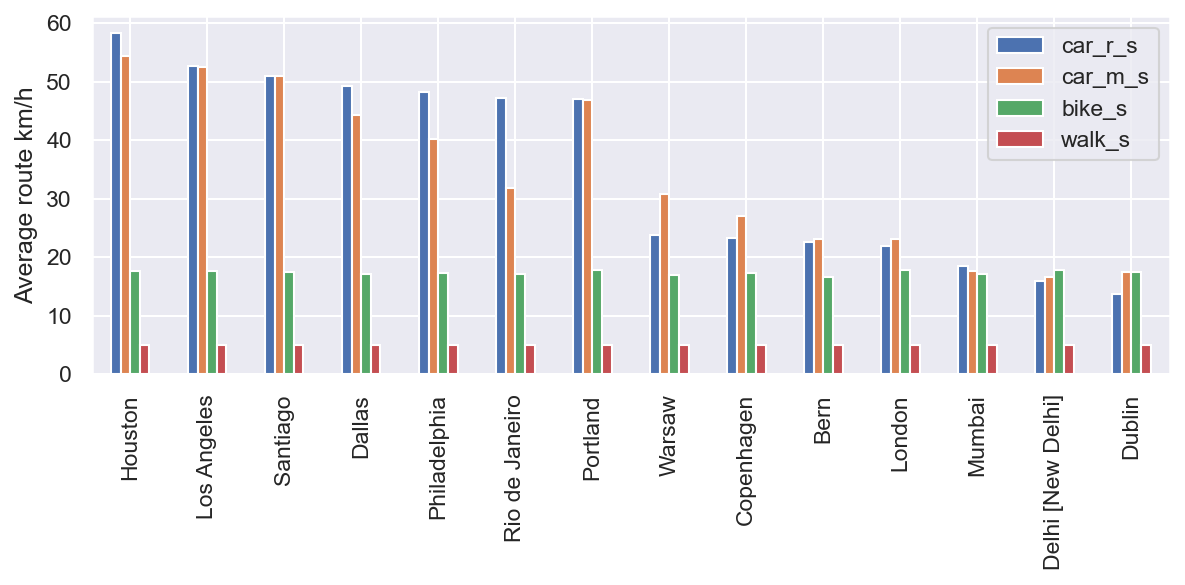

In [15]:
# Create a plot and save it.
fig, ax = plt.subplots(figsize=(8,4), dpi=150, tight_layout=True)
both_ends = [0,1,2,3,4,5,6,-7,-6,-5,-4,-3,-2,-1]

# Loop over modes and save.
gdf_speed = gdf_speed.sort_values(by='car_r_s', ascending=False)
speeds_df = gdf_speed.iloc[both_ends].plot(kind='bar', legend=True, ax=ax)
ax.set_ylabel('Average route km/h')
ax.set_xlabel('')
plt.savefig(os.path.join(DROOT, '5-graphs', 'avg-speed-modes.png'))